In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_stata("/Users/nickking/Desktop/Documents/University/Year 3/Dissertation/Python.dta")
df.head(10)

,uk_kof,mexico_kof,brazil_kof,us_kof,india_kof,brazil_interest,uk_interest,us_interest,mexico_interest,india_interest,...,error_rfmexico,error_rf_mvmexico,error_rf_sqmexico,error_rf_mv_sqmexico,loss_diff_bv_mv_mexico,rf_usmvante,rf_ukmvante,rf_mexicomvante,rf_indiamvante,rf_brazilmvante
0,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,87.139824,61.742538,59.764328,79.653709,56.972511,17.25,5.25,4.5,7.77,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(list(df.columns))

['uk_kof', 'mexico_kof', 'brazil_kof', 'us_kof', 'india_kof', 'brazil_interest', 'uk_interest', 'us_interest', 'mexico_interest', 'india_interest', 'us_close', 'vix_close', 'vix_volume_y', 'uk_close', 'india_close', 'brazil_close', 'mexico_close', 'monthly_date', 't', 'log_us_volume', 'log_uk_volume', 'log_india_volume', 'log_brazil_volume', 'log_mexico_volume', 'log_brazil_epu', 'log_uk_epu', 'log_us_epu', 'log_india_epu', 'log_mexico_epu', 'log_volatility_close', 'log_gepu', 'log_brazil_kof', 'log_uk_kof', 'log_india_kof', 'log_mexico_kof', 'log_us_kof', 'uk_NEXP_GDP', 'us_NEXP_GDP', 'brazil_NEXP_GDP', 'mexico_NEXP_GDP', 'india_NEXP_GDP', 'return_brazil_close', 'return_us_close', 'return_uk_close', 'return_india_close', 'return_mexico_close', 'squreturn_india_close', 'squreturn_brazil_close', 'squreturn_uk_close', 'squreturn_mexico_close', 'squreturn_us_close', 'log_usrisk', 'log_mexicorisk', 'log_brazilrisk', 'log_indiarisk', 'log_ukrisk', 'shade1', 'shade2', 'shade', 'ymin', 'ymax'

In [4]:
countries = ['us']
train_size = 3500
test_start = 4000
forecast_horizon = 1

results = []

for country in countries:
    print(f"--- Processing country: {country.upper()} ---")

    ret_col = f'return_{country}_close'
    risk_col = f'log_{country}risk'
    volume_col = f'log_{country}_volume'
    interest_col = f'{country}_interest'
    nexpgdp_col = f'{country}_NEXP_GDP'
    volatility_col = 'log_volatility_close'
    garch_col = f'volatility{country}mv'

    df[f'return_lag1_{country}'] = df[ret_col].shift(1)
    df[f'return_lag2_{country}'] = df[ret_col].shift(2)

    required_cols = [
        ret_col,
        f'return_lag1_{country}',
        f'return_lag2_{country}',
        risk_col,
        volume_col,
        interest_col,
        volatility_col,
        nexpgdp_col,
        garch_col
    ]
    df_filtered = df.dropna(subset=required_cols).copy()
    df_filtered = df_filtered.reset_index(drop=True)

    print(f"{country.upper()} df shape before filtering: {df.shape}")
    print(f"{country.upper()} df shape after filtering: {df_filtered.shape}")
    print(f"Missing values per column after filtering:\n{df_filtered[required_cols].isnull().sum()}")

    features = [
        f'return_lag1_{country}', f'return_lag2_{country}',
        risk_col, volume_col, interest_col, volatility_col, nexpgdp_col, garch_col
    ]

    train = df_filtered.iloc[:train_size]
    X_train = train[features]
    y_train = train[ret_col]

    model = RandomForestRegressor(n_estimators=200, max_features=5, random_state=42)
    model.fit(X_train, y_train)

    preds = []
    actuals = []
    dates = []

    for i in range(test_start, len(df_filtered) - forecast_horizon + 1):
        test = df_filtered.iloc[i:i + forecast_horizon]
        X_test = test[features]
        y_test = test[ret_col].values
        y_pred = model.predict(X_test)

        for j in range(forecast_horizon):
            preds.append(y_pred[j])
            actuals.append(y_test[j])
            dates.append(test.index[j])

        if (i - test_start) % 100 == 0:
            print(f"Processing index {i}/{len(df_filtered) - forecast_horizon}")

    date_vals = [df_filtered.index[i] for i in dates]

    df_result = pd.DataFrame({
        'date': date_vals,
        f'actual_{country}': actuals,
        f'forecast_{country}': preds
    })

    results.append(df_result)

final = results[0]
for r in results[1:]:
    final = final.merge(r, on='date', how='outer')

print("\nSample merged results:")
print(final.head())


--- Processing country: US ---
US df shape before filtering: (4192, 217)
US df shape after filtering: (4184, 217)
Missing values per column after filtering:
return_us_close         0
return_lag1_us          0
return_lag2_us          0
log_usrisk              0
log_us_volume           0
us_interest             0
log_volatility_close    0
us_NEXP_GDP             0
volatilityusmv          0
dtype: int64


/var/folders/1m/k225dj3x4yz7mpfywd8kznt80000gn/T/ipykernel_16926/3567086198.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'return_lag1_{country}'] = df[ret_col].shift(1)
/var/folders/1m/k225dj3x4yz7mpfywd8kznt80000gn/T/ipykernel_16926/3567086198.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'return_lag2_{country}'] = df[ret_col].shift(2)


Processing index 4000/4183
Processing index 4100/4183

Sample merged results:
   date  actual_us  forecast_us
0  4000  -0.999417    -0.072403
1  4001   0.506724     0.268132
2  4002   0.992648     0.088366
3  4003  -0.685692     0.144044
4  4004   1.075739    -0.013647


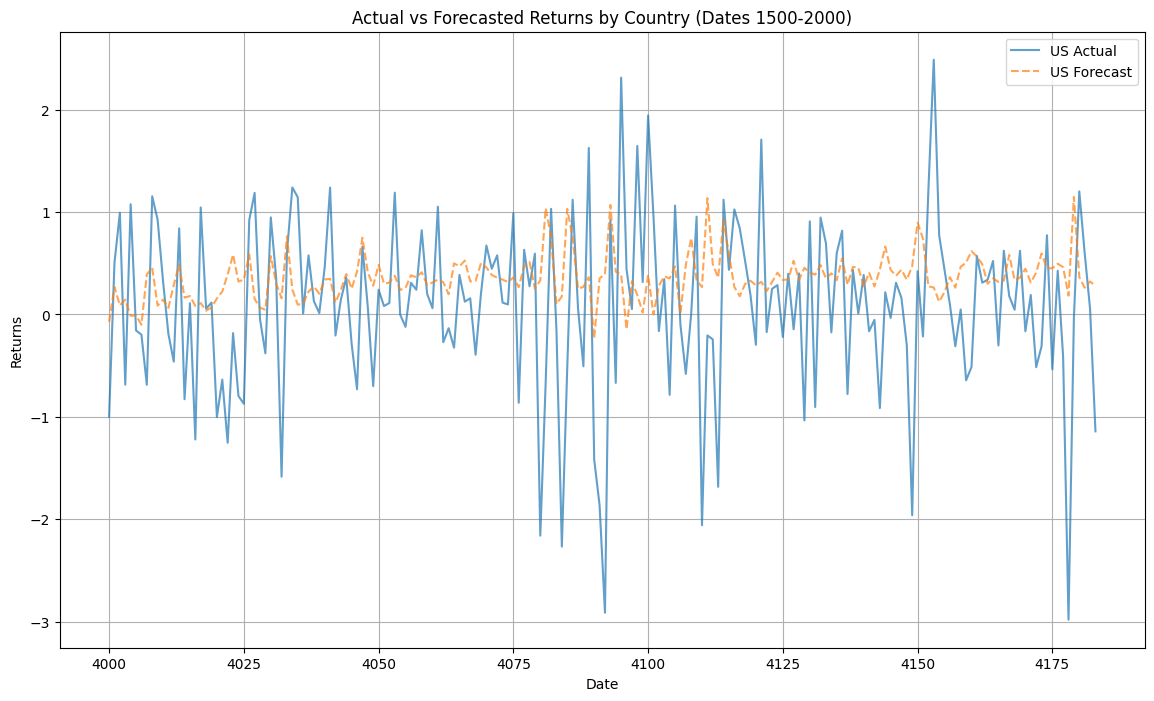

In [5]:
import matplotlib.pyplot as plt

mask = (final['date'] >= 4000) & (final['date'] <= 4184)
final_filtered = final.loc[mask]

plt.figure(figsize=(14, 8))

for country in countries:
    col_actual = f'actual_{country}'
    col_forecast = f'forecast_{country}'

    if col_actual in final_filtered.columns and col_forecast in final_filtered.columns:
        plt.plot(final_filtered['date'], final_filtered[col_actual], label=f'{country.upper()} Actual', alpha=0.7)
        plt.plot(final_filtered['date'], final_filtered[col_forecast], label=f'{country.upper()} Forecast', alpha=0.7, linestyle='--')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Actual vs Forecasted Returns by Country (Dates 1500-2000)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
countries = ['us']
window_size = 1000
forecast_horizon = 1  
retrain_every = 5  

results = []

for country in countries:
    print(f"--- Processing country: {country.upper()} ---")

    ret_col = f'return_{country}_close'
    risk_col = f'log_{country}risk'
    volume_col = f'log_{country}_volume'
    interest_col = f'{country}_interest'
    nexpgdp_col = f'{country}_NEXP_GDP'
    volatility_col = 'log_volatility_close'
    garch_col = f'volatility{country}mv'

    df[f'return_lag1_{country}'] = df[ret_col].shift(1)
    df[f'return_lag2_{country}'] = df[ret_col].shift(2)

    required_cols = [
        ret_col,
        f'return_lag1_{country}',
        f'return_lag2_{country}',
        risk_col,
        volume_col,
        interest_col,
        volatility_col,
        nexpgdp_col,
        garch_col
    ]
    df_filtered = df.dropna(subset=required_cols).copy()

    print(f"{country.upper()} df shape before filtering: {df.shape}")
    print(f"{country.upper()} df shape after filtering: {df_filtered.shape}")
    print(f"Missing values per column after filtering:\n{df_filtered[required_cols].isnull().sum()}")

    preds = []
    actuals = []
    dates = []

    features = [
        f'return_lag1_{country}', f'return_lag2_{country}',
        risk_col, volume_col, interest_col, volatility_col, nexpgdp_col, garch_col
    ]

    model = RandomForestRegressor(n_estimators=200, max_features=5, random_state=42)

    print(f"{country.upper()} Length for forecasting: {len(df_filtered)}")
    print(f"Window size: {window_size}, Forecast horizon: {forecast_horizon}")
    print(f"Retraining every {retrain_every} steps")

    model_trained = False

    for i in range(window_size, len(df_filtered) - forecast_horizon + 1):
        if ((i - window_size) % retrain_every == 0) or not model_trained:
            train = df_filtered.iloc[i - window_size:i]
            X_train = train[features]
            y_train = train[ret_col]
            model.fit(X_train, y_train)
            model_trained = True

        test = df_filtered.iloc[i:i + forecast_horizon]
        X_test = test[features]
        y_test = test[ret_col].values

        y_pred = model.predict(X_test)

        for j in range(forecast_horizon):
            preds.append(y_pred[j])
            actuals.append(y_test[j])
            dates.append(test.index[j])

        if (i - window_size) % 100 == 0:
            print(f"Processing index {i}/{len(df_filtered) - forecast_horizon}")

    df_result = pd.DataFrame({
        'date': dates,
        f'actual_{country}': actuals,
        f'forecast_{country}': preds
    })

    results.append(df_result)

final = results[0]
for r in results[1:]:
    final = final.merge(r, on='date', how='outer')

print("\nSample merged results:")
print(final.head())


--- Processing country: US ---
US df shape before filtering: (4192, 217)
US df shape after filtering: (4184, 217)
Missing values per column after filtering:
return_us_close         0
return_lag1_us          0
return_lag2_us          0
log_usrisk              0
log_us_volume           0
us_interest             0
log_volatility_close    0
us_NEXP_GDP             0
volatilityusmv          0
dtype: int64
US Length for forecasting: 4184
Window size: 1000, Forecast horizon: 1
Retraining every 5 steps
Processing index 1000/4183
Processing index 1100/4183
Processing index 1200/4183
Processing index 1300/4183
Processing index 1400/4183
Processing index 1500/4183
Processing index 1600/4183
Processing index 1700/4183
Processing index 1800/4183
Processing index 1900/4183
Processing index 2000/4183
Processing index 2100/4183
Processing index 2200/4183
Processing index 2300/4183
Processing index 2400/4183
Processing index 2500/4183
Processing index 2600/4183
Processing index 2700/4183
Processing ind

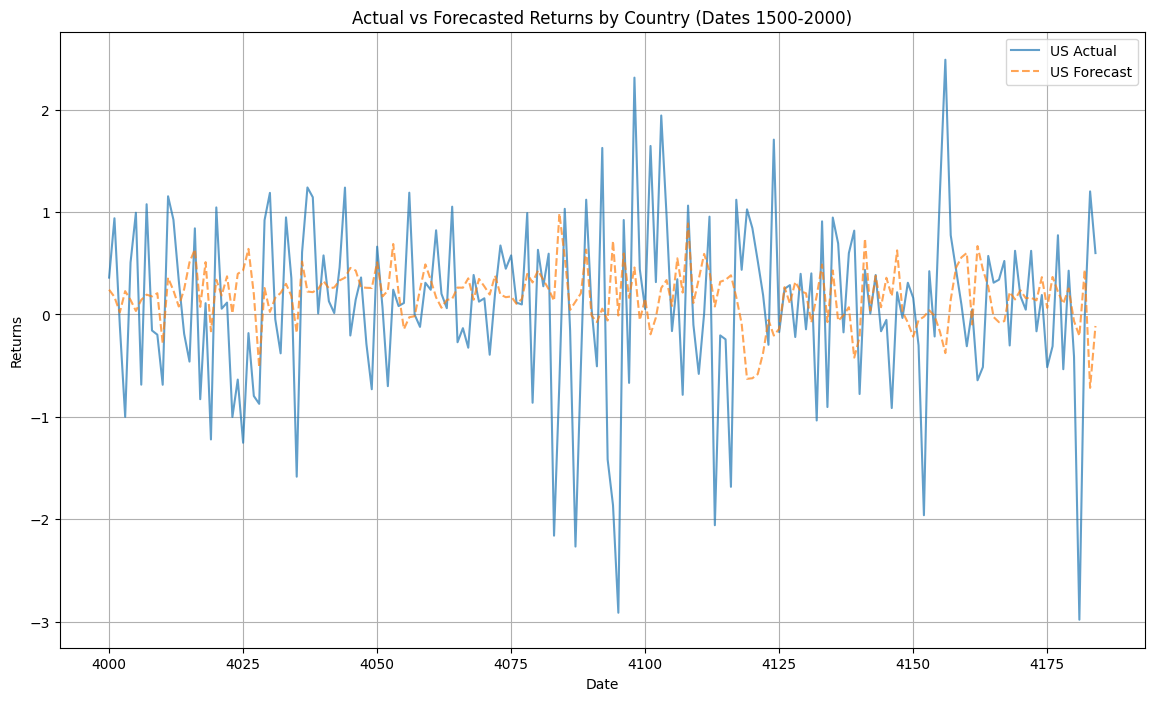

In [8]:
import matplotlib.pyplot as plt

mask = (final['date'] >= 4000) & (final['date'] <= 4184)
final_filtered = final.loc[mask]

plt.figure(figsize=(14, 8))

for country in countries:
    col_actual = f'actual_{country}'
    col_forecast = f'forecast_{country}'

    if col_actual in final_filtered.columns and col_forecast in final_filtered.columns:
        plt.plot(final_filtered['date'], final_filtered[col_actual], label=f'{country.upper()} Actual', alpha=0.7)
        plt.plot(final_filtered['date'], final_filtered[col_forecast], label=f'{country.upper()} Forecast', alpha=0.7, linestyle='--')

plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Actual vs Forecasted Returns by Country (Dates 1500-2000)')
plt.legend()
plt.grid(True)
plt.show()


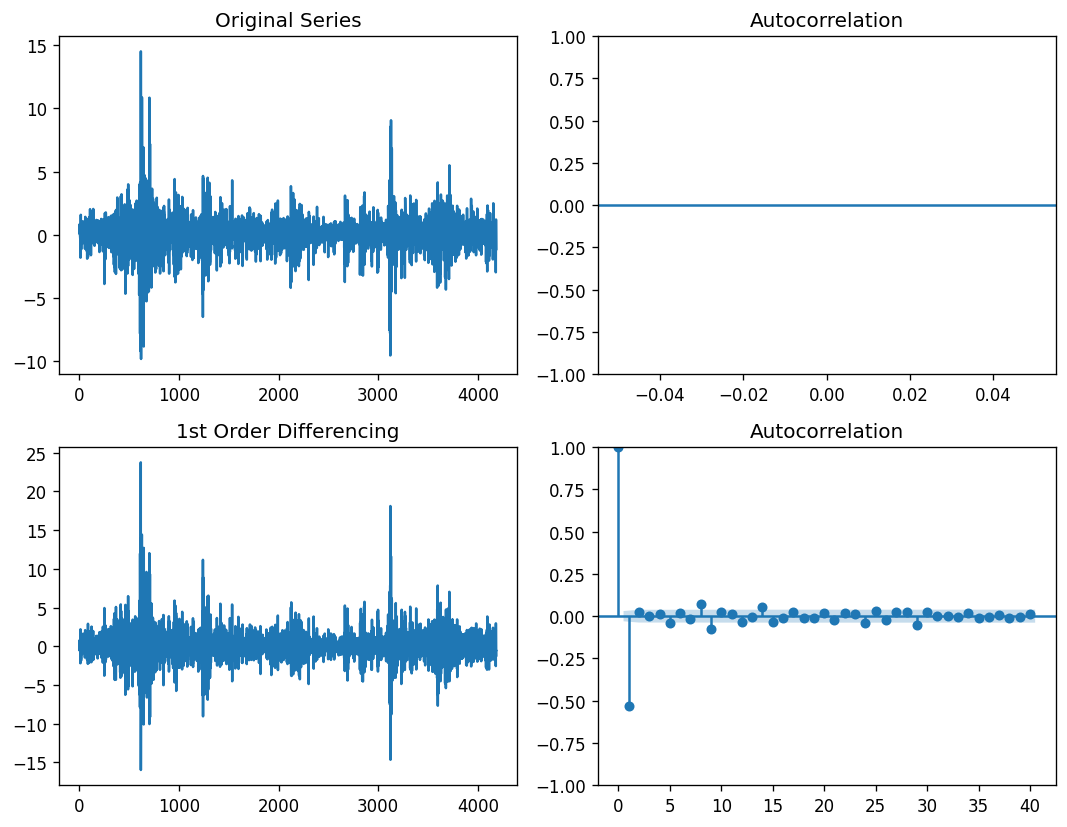

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(df.return_us_close)
axes[0, 0].set_title('Original Series')
plot_acf(df.return_us_close, ax=axes[0, 1], lags=40)

axes[1, 0].plot(df.return_us_close.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.return_us_close.diff().dropna(), ax=axes[1, 1], lags=40)

plt.tight_layout()
plt.show()


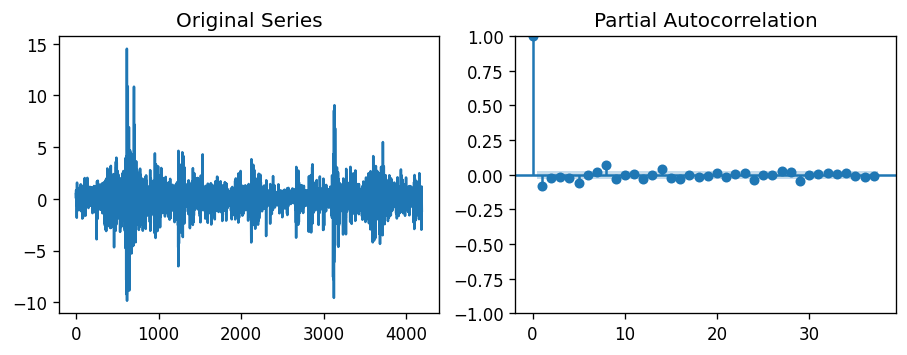

In [30]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.return_us_close); axes[0].set_title('Original Series')
axes[1].set(ylim=(0,5))
plot_pacf(df.return_us_close.dropna(), ax=axes[1])

plt.show()

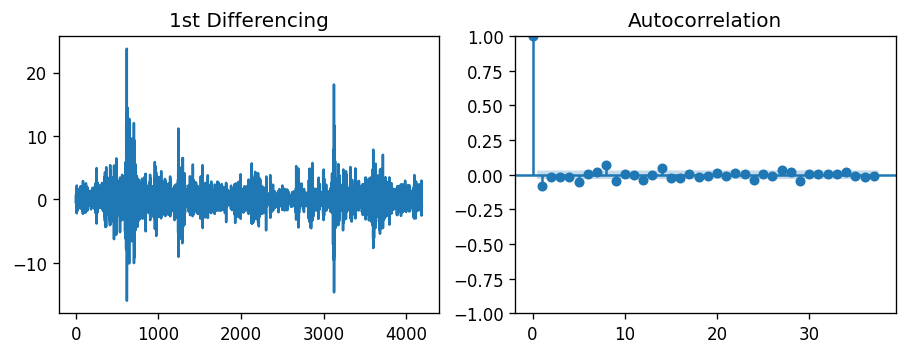

In [33]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(df.return_us_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.return_us_close.dropna(), ax=axes[1])

plt.show()

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.return_us_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        return_us_close   No. Observations:                 4192
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6962.646
Date:                Thu, 12 Jun 2025   AIC                          13931.293
Time:                        15:28:03   BIC                          13950.315
Sample:                             0   HQIC                         13938.020
                               - 4192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0819      0.007    -11.063      0.000      -0.096      -0.067
ma.L1         -1.0000      0.024    -41.768      0.000      -1.047      -0.953
sigma2         1.6222      0.043     38.024      0.0

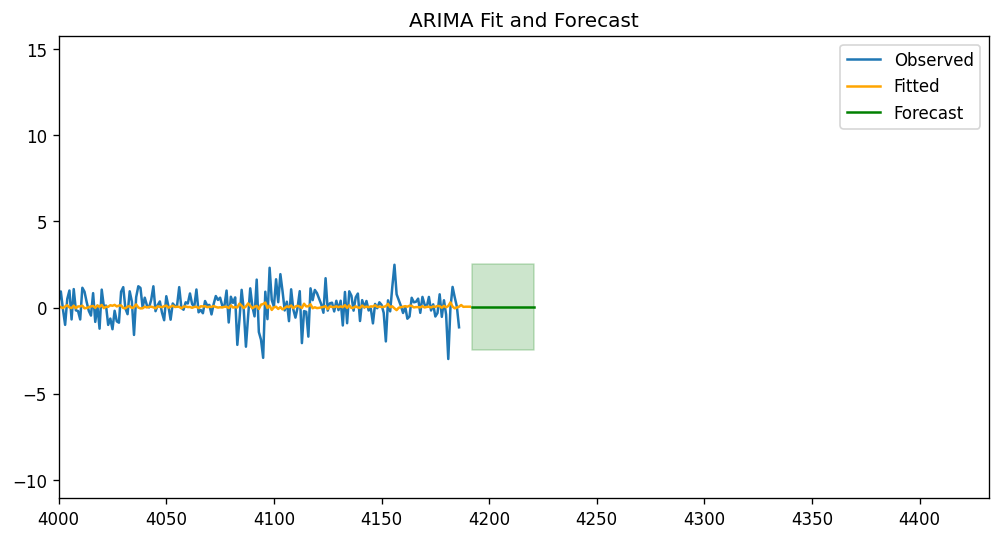

In [48]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot observed data
df['return_us_close'].plot(ax=ax, label='Observed')

# Plot in-sample fitted values
model_fit.fittedvalues.plot(ax=ax, label='Fitted', color='orange')

# Forecast next 30 steps
forecast = model_fit.get_forecast(steps=30)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot forecast and confidence interval
forecast_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)

ax.set_xlim(left=4000)

ax.legend()
plt.title('ARIMA Fit and Forecast')
plt.show()
